In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from math import *
import pyomo.environ as pe


In [58]:
# functions to be used for calculations, plotting, etc.

def ent_rate_memory_exact(p_list,W):
    # calculates the e2e rate of a path with a list of success prob
    # and W memories
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])

def ent_rate_memory_gaussian(p_list,W, Wmax = 100):
    N = len(p_list)
    Q = np.zeros((Wmax,N))
    P = np.zeros((Wmax,N))
    for k in range(N):
        p_k = p_list[k]
        for i in range(Wmax):
            Q[i,k] = gaussian_dist(i+1,W*p_k,sqrt(W*p_k*(1-p_k))) 
            
    P[:,0] = Q[:,0]
    for k in range(1,N):
        for i in range(Wmax):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1]) 
    return np.sum(np.arange(1,Wmax+1)*P[:,-1])


def binomial_dist(i,W,p_k):
    return comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

def gaussian_dist(x,μ,σ):
    return 1/(σ*sqrt(2*pi))*np.exp(-(x-μ)**2/σ**2/2)

def pe_gaussian_dist(x,μ,σ):
    return 1/(σ*pe.sqrt(2*pi))*pe.exp(-(x-μ)**2/σ**2/2)


def ent_calc_x(user_pair,x_opt,w_opt,Wmax = 100):
    num_nodes = len(R_list)
    Q = np.zeros((Wmax,2+num_nodes**2))
    P = np.zeros(Wmax)

    t = t_list[user_pair]
         
    for i in range(Wmax):
        for n1 in (list(R_list)+ [t]):
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
            Q[i,0] += x_opt[user_pair,s,n1]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
            P[i] += x_opt[user_pair,s,n1]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 

    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            if n2 != n1:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                for i in range(Wmax):
                    Q[i,i1*num_nodes+i2+1] = gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 

    counter = 0 
    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            for i in range(Wmax):
                P[i] = P[i]* (np.sum(Q[i:,counter+1])**x_opt[user_pair,n1,n2]) + x_opt[user_pair,n1,n2]*Q[i,counter+1]* np.sum(P[i+1:]) 
            counter += 1

    for n1 in R_list:
        p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
        for i in range(Wmax):
            Q[i,-1] += x_opt[user_pair,n1,t]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
    for i in range(Wmax):
        P[i] = P[i]* np.sum(Q[i:,-1])**np.sum( x_opt[user_pair,R_list,t]) + np.sum( x_opt[user_pair,R_list,t])* Q[i,-1]* np.sum(P[i+1:]) 
    return np.sum(np.arange(1,Wmax+1)*P)

def plot_output(x_opt,y_opt):
    plt.figure(figsize=(4,3))
    for i,y_val in enumerate(y_opt):
        if i not in np.concatenate((s_list,t_list)):
            if y_val == 1:
                plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
                plt.text(pos[i][0],pos[i][1],"%d" % i)
            else:
                plt.plot(pos[i][0],pos[i][1],"bo")
                plt.text(pos[i][0],pos[i][1],"%d" % i)

    for e in G.edges():
        plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)
    colors = ["violet","orange","gray","green"]
    for user_pair in range(C):
        s = s_list[user_pair]
        plt.plot(pos[s][0],pos[s][1],"s", color = colors[user_pair])
        plt.text(pos[s][0],pos[s][1],"%d" % s)
        t = t_list[user_pair]
        plt.plot(pos[t][0],pos[t][1],"s", color = colors[user_pair])
        plt.text(pos[t][0],pos[t][1],"%d" % t)

        edges = np.argwhere(x_opt[user_pair,:,:]>0.5)
        path_output = []
        for e in edges:
            if G.has_edge(e[0],e[1]):
                plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
                path_output.append(list(e))
            else:
                if nx.has_path(G, source=e[0], target=e[1]):
                    path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
                    path_output.append(path)
                    for i in range(len(path)-1):
                        e1 = path[i]
                        e2 = path[i+1]
                        plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)

        print((s_list[user_pair],t_list[user_pair]),":",path_output)
#     plt.xlim([0,L0])
#     plt.xlim([0,L0])
    plt.show()
    


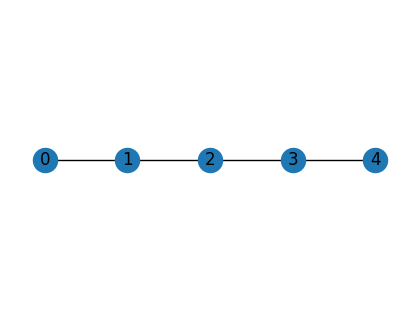

In [23]:
# network graph
N = 5# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 30
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
adj_mat += adj_mat.T

pos = dict()
for node in range(N):
    pos[node] = (p*node,0)
    
G = nx.from_numpy_array(adj_mat)
plt.figure(figsize=(4,3))
nx.draw(G, pos = pos,  with_labels=True)
plt.show()


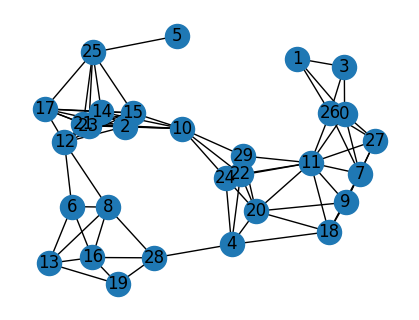

In [60]:
# random network graph of N nodes
N = 30# number of nodes
node_list = np.arange(N)

# nodes are distributed uniformly within an L0xL0 square
L0 = 100 # square dim in km
length = L0
width = L0
# dmax = 0.35*L0 # cut off for elementary links
# random.seed(33)
dmax = 0.3*L0
random.seed(20)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)

weights = dict()
transmission = dict()
for e in G.edges():
    dist = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    weights[e] = dist
    transmission[e] = 10**(-0.2*dist/10)
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = transmission, name = 'trans')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()


## Utility maximization
multiuser, one memory per $q=(s,d)$
Considering end-to-end success probability
$$R_{e2e}(s,d) = \prod_{(u,v)\in {\cal E}_{q}} \left(1-(1-p_{uv})^M \right)^{x^q_{uv}}$$
and fidelity
$$F_{e2e}(s,d) = \frac{3}{4} \prod_{(u,v)\in {\cal E}_{q}} \left(\frac{4 F_{uv}-1}{3}\right)^{x^q_{uv}}+\frac{1}{4}$$
Assuming a uniform network where the fidelity is equal to $F_e$ for each link, this can be simplified into
$$F_{e2e}(s,d) = \frac{3}{4}  \left(\frac{4 F_{e}-1}{3}\right)^{\sum_{(u,v)\in {\cal E}_{q}} x^q_{uv}}+\frac{1}{4}$$
We use the utility associated with the entanglement negativity,
$$U(R_{e2e},F_{e2e}) = \log\left( R_{e2e} \left( F_{e2e}- 1/2 \right)\right)$$
provided that $F_{e2e}> 1/2$.

## pyomo implementation 

$$\max \sum_{(s,d)} U( R_{e2e}(s,d),F_{e2e}(s,d))$$
$$\text{s.t.}\quad \sum_v x_{uv}^q - \sum_v x_{vu}^q 
\qquad = 1 \quad \text{if}\ u=s $$
$$\hspace{5.5cm} = -1 \quad \text{if}\ u=t $$
$$ \hspace{5.4cm} = 0 \quad \text{if}\ u\in {\cal R} $$

$$\sum_q \sum_v x_{uv}^q \leq D_u y_u \quad \forall u\in {\cal R}$$

$$\sum_u y_{u} \leq N_{\max} \quad \forall u\in {\cal R}$$

$$x_{uv}^q \in \{0, 1\}\qquad \forall (u,v) \in {\cal E}_q$$
$$y_{u} \in \{0, 1\}\qquad \forall u \in {\cal R}$$


In [29]:

Nmax = 1
D0 = 4
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination
# s_list = [10,12,13] # source
# t_list = [7,11,9] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
model.matrix = model.C*model.N*model.N
model.x = pe.Var(model.matrix, domain=pe.Binary)#,initialize=0)#,intitialize={(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}, default=0)
model.y = pe.Var(model.R, domain=pe.Binary,initialize=0)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
    for n1 in R_list:
        
        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
        for n2 in R_list:
            if n2 != n1:
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]

        model.constraints.add( path == 0 ) 
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

#############

def ObjRule(model):
    M = 10
    F = 0.9
    q = 0.8
    rate = 1
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
        for n1 in list(R_list):
            n_list = np.array(list(set(R_list)-{n1}))
            number += sum(model.x[user_pair,n1,i] for i in n_list)

        rate_user = 1
        for n1 in (list(R_list)+ [t]):
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
            rate *= (1-(1-p_k)**M)**model.x[user_pair,s,n1] 
            
        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                if n2 != n1:
                    p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                    rate *= (1-(1-p_k)**M)**model.x[user_pair,n1,n2] 

        for n1 in R_list:
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
            rate *= (1-(1-p_k)**M)**model.x[user_pair,n1,t] 
#         rate *= (rate_user*((1+3*((4*F-1)/3)**number)/4-0.5) )
        rate *= (q**number *( 3*((4*F-1)/3)**number- 1) )
#     return pe.log(rate)
    return ( 3*((4*F-1)/3)**number- 1)

    #################
model.constraints.add(expr= sum(model.y[i] for i in model.R) <= Nmax)
# model.objective = pe.Objective(expr= sum( model.y[i] for i in model.R), sense=pe.minimize)
# α = 0.1
# model.objective = pe.Objective(expr= path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)

# opt = pe.SolverFactory("bonmin",tee=True)
# opt = pe.SolverFactory("couenne",tee=True)
opt = pe.SolverFactory("baron",tee=True)
results = opt.solve(model)
results.write()

model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: problem
  Lower bound: 1.6
  Upper bound: 1.6000016
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 17
  Sense: unknown
  Missing bounds: 0
  Iterations: -1
  Node opt: -1
  Node memmax: 0
  Cpu time: 0.01
  Wall time: 0.01
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Error rc: 0
  Time: 0.03804636001586914
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 


(0, 4) : [[0, 1, 2, 3, 4]]


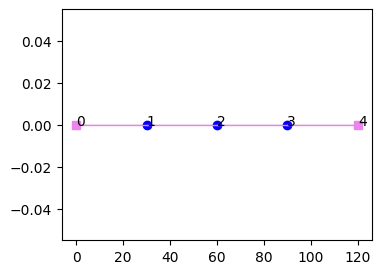

[0. 0. 0. 0. 0.]


In [30]:
plot_output(x_opt,y_opt)       
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )
 
print(y_opt)#, pe.value(rate[0]))
# print(path_prob)

 LP formulation

In [63]:

Nmax = 1
D0 = 4
D = D0*np.ones(N)
# s_list = [0] # source
# t_list = [N-1] # destination
# s_list = [10,12,13] # source
# t_list = [7,11,9] # destination
s_list = [13,8,17,12]
t_list = [7,3,9,7]

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
model.matrix = model.C*model.N*model.N
model.x = pe.Var(model.matrix, domain=pe.Binary)#,initialize=0)#,intitialize={(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}, default=0)
model.y = pe.Var(model.R, domain=pe.Binary,initialize=0)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
    for n1 in R_list:
        
        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
        for n2 in R_list:
            if n2 != n1:
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]

        model.constraints.add( path == 0 ) 
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

#############

def ObjRule(model):
    M = 10
    F = 0.95
    q = 0.5
    rate = 1
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
        for n1 in list(R_list):
            n_list = np.array(list(set(R_list)-{n1}))
            number += sum(model.x[user_pair,n1,i] for i in n_list)

        rate_user = 1
        for n1 in (list(R_list)+ [t]):
            if nx.has_path(G, source=s, target=n1):
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
                rate += model.x[user_pair,s,n1]*np.log(1-(1-p_k)**M) 
            
        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                if n2 != n1:
                    if nx.has_path(G, source=n1, target=n2):
                        p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                        rate += model.x[user_pair,n1,n2]*np.log(1-(1-p_k)**M) 

        for n1 in R_list:
            if nx.has_path(G, source=n1, target=t):
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
                rate += model.x[user_pair,n1,t]*np.log(1-(1-p_k)**M) 
#         rate *= (rate_user*((1+3*((4*F-1)/3)**number)/4-0.5) )
        rate += number*np.log(q) #*( 3*((4*F-1)/3)**number- 1) )
    return rate
#     return ( 3*((4*F-1)/3)**number- 1)
    #################
model.constraints.add(expr= sum(model.y[i] for i in model.R) <= Nmax)
# model.objective = pe.Objective(expr= sum( model.y[i] for i in model.R), sense=pe.minimize)
# α = 0.1
# model.objective = pe.Objective(expr= path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)

# opt = pe.SolverFactory("bonmin",tee=True)
# opt = pe.SolverFactory("couenne",tee=True)
opt = pe.SolverFactory("cbc",tee=True)
results = opt.solve(model)
results.write()

model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -10.35626657
  Upper bound: -10.35626657
  Number of objectives: 1
  Number of constraints: 124
  Number of variables: 2235
  Number of binary variables: 2235
  Number of integer variables: 2235
  Number of nonzeros: 2212
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.9
  Wallclock time: 1.03
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] 1.0
(13, 7) : [[13, 16, 28, 4, 20], [20, 9, 7]]
(8, 3) : [[8, 28, 4, 20], [20, 11, 26, 3]]
(17, 9) : [[17, 14, 10, 24, 20], [20, 9]]
(12, 7) : [[12, 2, 10, 29, 11, 7]]


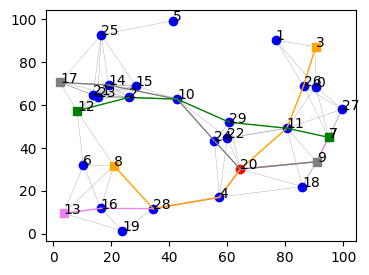

In [64]:
# plot_output(x_opt,y_opt)       
# for user_pair in range(C):
#     s = s_list[user_pair]
#     t = t_list[user_pair]
# #     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )
 
# print(y_opt)#, pe.value(rate[0]))
# print(path_prob)
y_opt = np.zeros(N)
for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += x_opt[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += x_opt[user_pair,n1,n2]
    if sum1_const>0.5:
        y_opt[n1] = 1
print(y_opt,np.sum(y_opt))
plot_output(x_opt,y_opt)       


## Utility maximization
multiuser, one memory per $q=(s,d)$ with $w$ memory multiplexing 
$$Q^i_k = \left(^w_i\right) p_k^i (1-p_k)^{w-i} $$
$$P_1^i = Q_1^i$$
$$P_k^i = P_{k-1}^i (\sum_{l=i}^w Q_{uv}^l)^{x_{uv}^q}+ {x_{uv}^q} Q_{uv}^i \sum_{l=i+1}^w P_{k-1}^l$$
Considering end-to-end success probability
$$R_{e2e}(s,d) = \sum_{i=1}^w i P_{e2e}^i$$
and similar formula for the fidelity as before.
We approximate the binomial distribution with a Gaussian distribution ${\cal N}(wp_k,wp_k(1-p_k))$.

We use the utility associated with the entanglement negativity.


## pyomo implementation 

$$\max \sum_{(s,d)} U( R_{e2e}(s,d),F_{e2e}(s,d))$$
$$\text{s.t.}\quad \sum_v x_{uv}^q - \sum_v x_{vu}^q 
\qquad = 1 \quad \text{if}\ u=s $$
$$\hspace{5.5cm} = -1 \quad \text{if}\ u=t $$
$$ \hspace{5.4cm} = 0 \quad \text{if}\ u\in {\cal R} $$

$$\sum_q \sum_v w^q x_{uv}^q \leq D_u y_u \quad \forall u\in {\cal R}$$

$$\sum_u y_{u} \leq N_{\max} \quad \forall u\in {\cal R}$$

$$x_{uv}^q \in \{0, 1\}\qquad \forall (u,v) \in {\cal E}_q$$
$$y_{u} \in \{0, 1\}\qquad \forall u \in {\cal R}$$


In [72]:
# # pe.value(model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) )
# # pe.value(ObjRule(model))
# # # for j in range(q_size):
# # for i in range(Wmax):
# #     print(pe.value(P[i]))

# # for j in range(q_size):
# #     for i in range(Wmax):
# #         print(pe.value(Q[i][j]))
# # print(x_opt[0,5,3])

### possible initialization
vec = dict()
for i1 in range(N):
    for i2 in range(N):
        if i2 == i1+1:
            vec[(0,i1,i2)]=1
        else:
            vec[(0,i1,i2)]=0
# vec[(0,0,1)] = 1
# vec[(0,1,3)] = 1
# print(vec)
# {(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}


In [73]:

Nmax = 2
w = 1
D0 = 1*w
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary,initialize=vec)
model.y = pe.Var(model.R, domain=pe.Binary,initialize=1)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += w*model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    for n1 in range(N):
        model.constraints.add(  model.x[user_pair,n1,n1] == 0 ) 
        model.constraints.add(  model.x[user_pair,n1,s] == 0 ) 
        model.constraints.add(  model.x[user_pair,t,n1] == 0 ) 

    for n1 in R_list:
        
        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
        for n2 in R_list:
            if n2 != n1:
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]

        model.constraints.add( path == 0 ) 
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

#############
F = 0.999
def ObjRule(model):
    Wmax = w
    num_nodes = len(R_list)
    q_size = 2+num_nodes**2
    Q = np.array([[0]*q_size]*Wmax).tolist()
    P = [None]*Wmax
    rate = 1 #[None]*C
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
        for n1 in list(R_list):
            n_list = np.array(list(set(R_list)-{n1}))
            number += sum(model.x[user_pair,n1,i] for i in n_list)

        for i in range(Wmax):
            q_sum = 0
            for n1 in (list(R_list)+ [t]):
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
                q_sum += model.x[user_pair,s,n1]*gaussian_dist(i+1,w*p_k,sqrt(w*p_k*(1-p_k))) 
            P[i] = q_sum 

        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                k = i1*num_nodes+i2+1
                if n2 != n1:
                    p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                    for i in range(Wmax):
                        Q[i][k]  = gaussian_dist(i+1,w*p_k,sqrt(w*p_k*(1-p_k))) 

        counter = 0 
        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                k = i1*num_nodes+i2+1
#                 if n2!= n1:
                for i in range(Wmax):
#                         P[i] = P[i]* (np.sum(np.array(Q)[i:,k])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][k] * np.sum(P[i+1:])      
                    P[i] = P[i]* (np.sum(np.array(Q)[i:,counter+1])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][counter+1] * np.sum(P[i+1:])      
                counter += 1

        for i in range(Wmax):
            q_sum = 0
            for n1 in R_list:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
                q_sum  += model.x[user_pair,n1,t]*gaussian_dist(i+1,w*p_k,pe.sqrt(w*p_k*(1-p_k))) 
            Q[i][-1] =  q_sum 

        t_sum = sum(model.x[user_pair,i,t] for i in model.R)
        for i in range(Wmax):
            P[i] = P[i]* np.sum(np.array(Q)[i:,-1])**t_sum + t_sum* Q[i][-1]* np.sum(P[i+1:]) 
        rate *= ( ( 3*((4*F-1)/3)**number- 1)*np.sum(np.arange(1,Wmax+1)*P )  )
#         rate *= np.sum(np.arange(1,Wmax+1)*P )  
#     print(pe.value(number), pe.value(rate))
    return rate
#     return pe.log(rate)

    #################
model.constraints.add(expr= sum(model.y[i] for i in model.R) <= Nmax)
model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)

opt = pe.SolverFactory("baron",tee=True)
results = opt.solve(model)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: problem
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 20
  Number of variables: 19
  Sense: unknown
  Missing bounds: 0
  Iterations: -1
  Node opt: -2
  Node memmax: 0
  Cpu time: 0.0
  Wall time: 0.0
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Error rc: 0
  Time: 0.0413970947265625
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number 

(0, 3) : [[0, 1], [1, 2], [2, 3]]


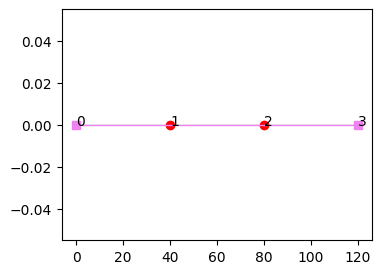

[0. 1. 1. 0.]
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.0009009131995144097


In [74]:
plot_output(x_opt,y_opt)       
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )
 
print(y_opt)#, pe.value(rate[0]))
# print(path_prob)
# print(pe.value(ObjRule(model)))
model.objective.display()


In [71]:
model.pprint()


5 Set Declarations
    C : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    1 :    {0,}
    N : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}
    R : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   19 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     3 :  C*N*N :   16 : {(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3)}

2 Var Declarations
    x : Siz

In [390]:
n_hop = 1
F_e2e = ((1+3*((4*F-1)/3)**n_hop)/4-0.5)
print(pe.value(ObjRule(model)),ent_calc_x(0,x_opt,w,Wmax = w)*F_e2e)
print(x_opt)
x0 = np.zeros((1,N,N))
x0[0,:,:] =np.diag(np.ones(N-1),1)
# x0[0,0,2] = 1
# x0[0,2,4] = 1
# print(x0)
n_hop = 2
F_e2e = ((1+3*((4*F-1)/3)**n_hop)/4-0.5)
print(ent_calc_x(0,x0,w,Wmax = w)*F_e2e)

# model = pe.ConcreteModel()

# model.R = pe.Set(initialize=R_list)
# model.N = pe.Set(initialize=range(N)) 
# model.C = pe.Set(initialize=range(C))
# model.matrix = model.C*model.N*model.N
# model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary,initialize=vec)
# model.y = pe.Var(model.R, domain=pe.Binary,initialize=0)
# # x0 = np.zeros((N,N))
# # for n1 in range(N):
# #     for n2 in range(N):
# #         x0[n1,n2] = pe.value(model.x[0,n1,n2])
# print(pe.value(ObjRule(model)))

0.10388225339239084 0.10388225339239084
[[[0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
0.32007574721071347
